In [61]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

from ..src import View

TARGET_IMG = 'images/rainy.jpg'
SRC_IMG = 'images/road.jpg'
IMG_SIZE = (640, 640)

In [62]:
# read in the images
target_img = cv2.imread(TARGET_IMG)
src_img = cv2.imread(SRC_IMG)

# conver to rgb
target_img = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)
src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

# resize to IMG_SIZE
target_img = cv2.resize(target_img, IMG_SIZE)
src_img = cv2.resize(src_img, IMG_SIZE)

<Figure size 1000x600 with 0 Axes>

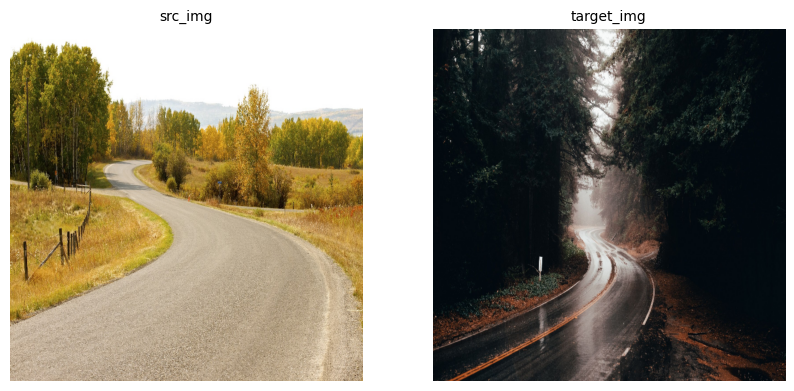

In [63]:
# plot the images
View.compare_color(np.stack([src_img, target_img]), labels=['src_img', 'target_img'], label_cols=True)

In [64]:
def calc_hist(img:np.ndarray) -> np.ndarray:
    hist = np.zeros(shape=(256), dtype=np.uint64)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            hist[img[x, y]] += 1
    return hist

In [65]:
# convert images to hsv
target_img_hsv = cv2.cvtColor(target_img, cv2.COLOR_RGB2HSV)
src_img_hsv = cv2.cvtColor(src_img, cv2.COLOR_RGB2HSV)

In [66]:
def get_mean_std(img:np.ndarray) -> tuple[float, float]:     
    if len(img.shape) == 2:
        img = img[..., np.newaxis]  
        
    gray = np.mean(img.copy(), axis=2)      # convert to grayscale  
    sigma = np.std(gray)      # get deviation of each grayscale image
    mu = np.mean(gray)        # get mean of each grayscale image
    
    return mu, sigma  # return the average of the means and deviations

In [67]:
def cb_remap(img:np.ndarray, mu, sigma) -> np.ndarray:
    # get mu and sigma from the source image
    img_mu, img_sigma = get_mean_std(img)
    
    contrast = sigma / img_sigma
    brightness = mu - img_mu
    
    new_img = (img.copy() - (255/2)) * contrast + (255/2) + brightness
    new_img = np.clip(new_img, 0, 255)
            
    return new_img.astype(np.uint8)

Target mean: 45.53428466796875, Target std: 48.67037995648295
Src mean: 180.369638671875, Src std: 56.62898934852244
New mean: 46.09567138671875, New std: 33.950873498943025


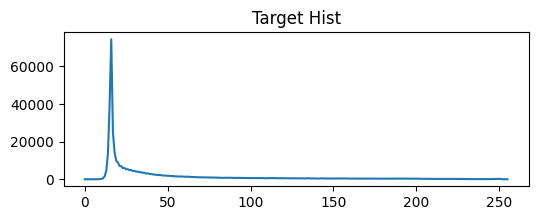

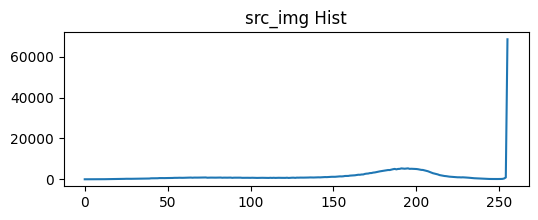

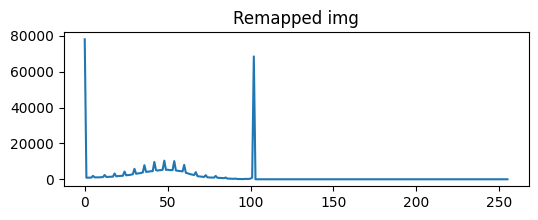

In [68]:
# get histogram of the target_img image
target_img_hist = calc_hist(target_img_hsv[:, :, 2])
src_img_hist = calc_hist(src_img_hsv[:, :, 2])

num_pixels = IMG_SIZE[0] * IMG_SIZE[1]

target_mu, target_sigma = get_mean_std(target_img_hsv[:, :, 2])
print(f'Target mean: {target_mu}, Target std: {target_sigma}')

src_mu, src_sigma = get_mean_std(src_img_hsv[:, :, 2])
print(f'Src mean: {src_mu}, Src std: {src_sigma}')

plt.figure(figsize=(6, 2))
plt.plot(target_img_hist)
plt.title('Target Hist')

plt.figure(figsize=(6, 2))
plt.plot(src_img_hist)
plt.title('src_img Hist')

#apply histogram remapping to the src_img image
remapped_src_img_hsv = src_img_hsv.copy()
remapped_src_img_hsv[:,:,2] = cb_remap(src_img_hsv[:, :, 2], target_mu, target_sigma)

remapped_mu, remapped_sigma = get_mean_std(remapped_src_img_hsv[:, :, 2])
print(f'New mean: {remapped_mu}, New std: {remapped_sigma}')


plt.figure(figsize=(6, 2))
plt.plot(calc_hist(remapped_src_img_hsv[:, :, 2]))
plt.title('Remapped img')


plt.show()

<Figure size 1000x600 with 0 Axes>

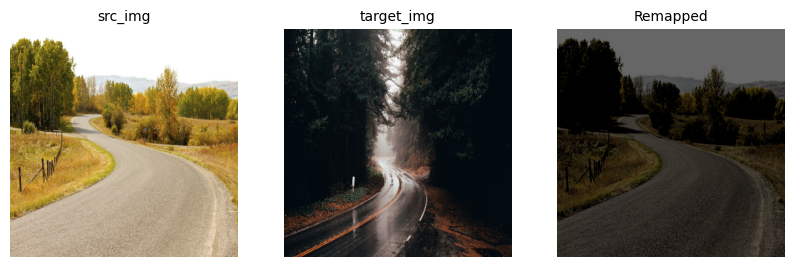

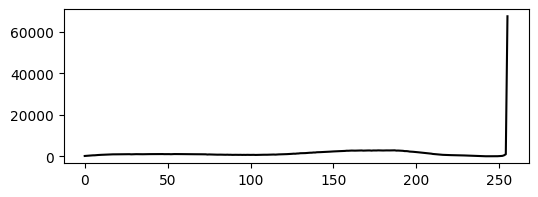

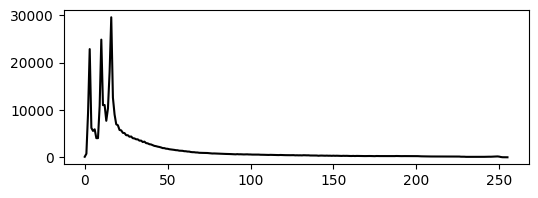

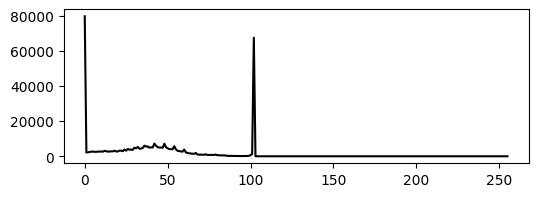

In [69]:
# convert back to rgb
remapped_src_img = cv2.cvtColor(remapped_src_img_hsv, cv2.COLOR_HSV2RGB)

# plot the images
View.compare_color(np.stack([src_img, target_img, remapped_src_img]), labels=['src_img', 'target_img', 'Remapped'], label_cols=True)

#plot histogram of the images
View.histogram(np.stack([src_img, target_img, remapped_src_img]), figsize=(6, 2), show_rgb=False)